DAE实现MNIST或FashionMNIST

In [ ]:
#加载相应包
!pip install memory_profiler
%load_ext memory_profiler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.manual_seed(0)
np.random.seed(0)

#超参数设置
num_epoch = 10
batch_size = 64
lr = 0.005
N_TEST_IMG = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
#下载数据
train_data = datasets.FashionMNIST(
  root = "data",
  train = True,
  transform = transforms.ToTensor(),
  download = True,
)
test_data = datasets.FashionMNIST(
  root = "data",
  train = False,
  transform = transforms.ToTensor(),
  download = True,
)
train_loader = DataLoader(train_data, batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size, shuffle = True)

In [ ]:
#定义网络模型，loss，优化器
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(28*28, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 12),
      nn.ReLU(),
      nn.Linear(12, 3),
    )
    self.decoder = nn.Sequential(
      nn.Linear(3, 12),
      nn.ReLU(),
      nn.Linear(12, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, 28*28),
      nn.Sigmoid(),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

model = Autoencoder().to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

def add_gaussian_noise(image, mean=0., std=0.5):
    noise = torch.randn(image.size(), device=image.device) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0., 1.)  # 限制数据在合理的范围内
    return noisy_image


In [ ]:
#训练
%%memit
model.train()
for epoch in range(num_epoch):
    for step, (images, _) in enumerate(train_loader):  # 标签不被使用
        images = images.to(device).view(-1, 28*28)
        noisy_images = add_gaussian_noise(images)  # 对输入图片添加噪声

        optimizer.zero_grad()
        _, decoded = model(noisy_images)  # 将带噪声的图片传入模型
        loss = loss_fn(decoded, images)  # 计算损失时使用原始干净的图片
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.0329
Epoch [2/10], Loss: 0.0348
Epoch [3/10], Loss: 0.0310
Epoch [4/10], Loss: 0.0267
Epoch [5/10], Loss: 0.0244
Epoch [6/10], Loss: 0.0224
Epoch [7/10], Loss: 0.0258
Epoch [8/10], Loss: 0.0200
Epoch [9/10], Loss: 0.0213
Epoch [10/10], Loss: 0.0226
peak memory: 997.62 MiB, increment: 210.60 MiB


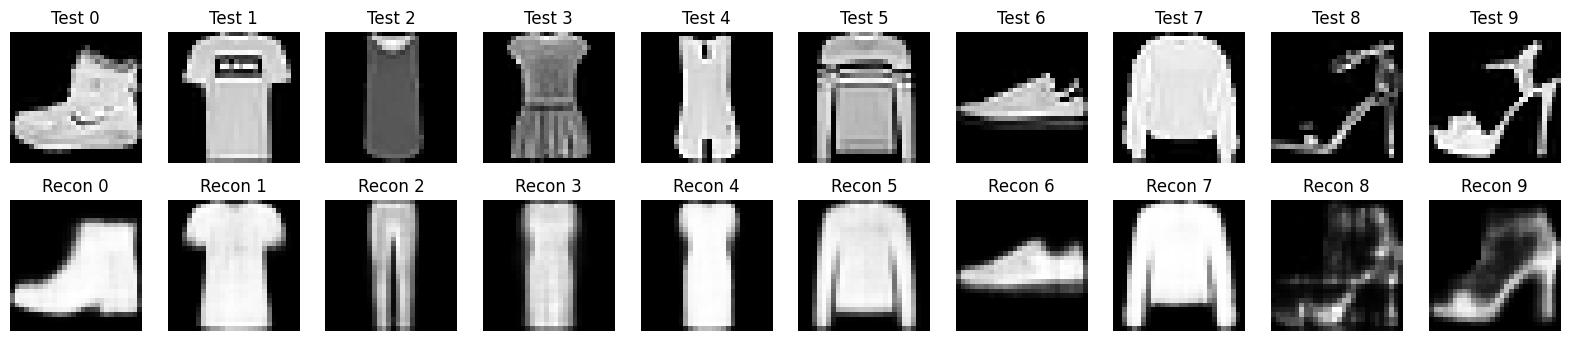

In [ ]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4))  # 2 行 10 列

for i in range(10):
    test_data = (train_data.data[i].view(-1, 28*28).type(torch.FloatTensor)/255).to(device)
    _, result = model(test_data)
    result = result.view(28, 28).detach().cpu().numpy()


    axs[0, i].imshow(train_data.data[i].cpu().numpy(), cmap='gray')
    axs[0, i].set_title('Test {}'.format(i))
    axs[0, i].axis('off')

    axs[1, i].imshow(result, cmap='gray')
    axs[1, i].set_title('Recon {}'.format(i))
    axs[1, i].axis('off')

plt.show()